In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
customer_parameters_df = pd.read_excel('Data/Customer Account Parameters.xlsx')

In [2]:
print("Columns:", customer_parameters_df.columns.tolist())

Columns: ['CUSTOMER_NUMBER', 'PARAMETER']


In [3]:
print("Sample data:\n", customer_parameters_df.head())

Sample data:
   CUSTOMER_NUMBER  PARAMETER
0          AACJ01     Closed
1          AACJC1     Closed
2          AACJC2  Promotion
3          AAVN01     Closed
4          ABLA01     Closed


In [4]:
print("Null values:\n", customer_parameters_df.isnull().sum())

Null values:
 CUSTOMER_NUMBER    0
PARAMETER          0
dtype: int64


In [5]:
# Remove rows with any null values
customer_parameters_df = customer_parameters_df.dropna()

In [6]:
print("Data shape:", customer_parameters_df.shape)

Data shape: (1090, 2)


In [7]:
#Read the JSON file of the enriched customer dataframe (including valid region and category codes+descriptions from customer_categories_cleaned.ipynb
customer_df = pd.read_json("customer_region_categories_df.json", lines=True)

customer_df

,CUSTOMER_NUMBER,CCAT_CODE,REGION_CODE,REP_CODE,SETTLE_TERMS,NORMAL_PAYTERMS,DISCOUNT,CREDIT_LIMIT,REGION_DESC,CCAT_DESC
0,AAMI01,41,10a,02,0,120,0,2000,Durban,KZN/DBN
1,ABHG01,49,10a,02,0,120,0,1500,Durban,KwaZulu-Natal / Durban
2,ABHG02,39,6a,04,0,120,0,2500,East Cape,Eastern Cape
3,ABHN01,49,10a,02,0,120,0,1500,Durban,KwaZulu-Natal / Durban
4,ABHN02,41,10a,02,0,30,0,500,Durban,KZN/DBN
...,...,...,...,...,...,...,...,...,...,...
1264,ZDOE01,30,7a,05,0,120,0,10000,Gauteng N - Sandton,Gauteng North - Sandton
1265,ZHAY02,19,4b,03,0,120,0,2000,Nelspruit / Tzaneen,Nelspruit / Tzaneen
1266,ZMAU01,37,11a,03,0,120,0,0,Free State / Lesotho,Free State
1267,ZNAE01,46,2b,05,0,120,0,30000,Krugersdorp / Sun City,Krugersdorp Suncity


In [8]:
# Define semantic groups for each parameter value
group_map = {
    "Closed": "Account Status",              # Indicates inactive or terminated accounts
    "Trading Account": "Account Status",     # Indicates active, revenue-generating accounts
    "Consignment": "Operations",             # Refers to stock handling model — fits better under 'Operations'
    "Promotion": "Marketing",                # Marketing behavior — fits under 'Marketing'
    "Promotional Stand": "Retail Format"     # Physical retail setup (e.g., kiosk, pop-up) — fits under 'Retail Format'
}

# Apply semantic grouping to the parameter field
customer_parameters_df['PARAMETER_GROUP'] = customer_parameters_df['PARAMETER'].map(group_map)

customer_parameters_df.columns.tolist()


['CUSTOMER_NUMBER', 'PARAMETER', 'PARAMETER_GROUP']

In [9]:
customer_parameters_df

,CUSTOMER_NUMBER,PARAMETER,PARAMETER_GROUP
0,AACJ01,Closed,Account Status
1,AACJC1,Closed,Account Status
2,AACJC2,Promotion,Marketing
3,AAVN01,Closed,Account Status
4,ABLA01,Closed,Account Status
...,...,...,...
1085,ZDEI01,Trading Account,Account Status
1086,ZDEIOC,Consignment,Operations
1087,ZDOE02,Closed,Account Status
1088,ZHAY01,Closed,Account Status


In [10]:
# Extract only rows that describe account status (Closed or Trading Account)
acc_status_df = customer_parameters_df[
    customer_parameters_df['PARAMETER_GROUP'] == "Account Status"
]

acc_status_df 

,CUSTOMER_NUMBER,PARAMETER,PARAMETER_GROUP
0,AACJ01,Closed,Account Status
1,AACJC1,Closed,Account Status
3,AAVN01,Closed,Account Status
4,ABLA01,Closed,Account Status
5,ABLE01,Closed,Account Status
...,...,...,...
1076,YMEEO6,Trading Account,Account Status
1079,YREN03,Trading Account,Account Status
1085,ZDEI01,Trading Account,Account Status
1087,ZDOE02,Closed,Account Status


In [11]:
# Merge ALL parameter rows with customer data
merged_df = customer_df.merge(
    customer_parameters_df[['CUSTOMER_NUMBER', 'PARAMETER', 'PARAMETER_GROUP']],
    on='CUSTOMER_NUMBER',
    how='left'
)

merged_df

,CUSTOMER_NUMBER,CCAT_CODE,REGION_CODE,REP_CODE,SETTLE_TERMS,NORMAL_PAYTERMS,DISCOUNT,CREDIT_LIMIT,REGION_DESC,CCAT_DESC,PARAMETER,PARAMETER_GROUP
0,AAMI01,41,10a,02,0,120,0,2000,Durban,KZN/DBN,NaN,NaN
1,ABHG01,49,10a,02,0,120,0,1500,Durban,KwaZulu-Natal / Durban,NaN,NaN
2,ABHG02,39,6a,04,0,120,0,2500,East Cape,Eastern Cape,NaN,NaN
3,ABHN01,49,10a,02,0,120,0,1500,Durban,KwaZulu-Natal / Durban,NaN,NaN
4,ABHN02,41,10a,02,0,30,0,500,Durban,KZN/DBN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1264,ZDOE01,30,7a,05,0,120,0,10000,Gauteng N - Sandton,Gauteng North - Sandton,NaN,NaN
1265,ZHAY02,19,4b,03,0,120,0,2000,Nelspruit / Tzaneen,Nelspruit / Tzaneen,NaN,NaN
1266,ZMAU01,37,11a,03,0,120,0,0,Free State / Lesotho,Free State,NaN,NaN
1267,ZNAE01,46,2b,05,0,120,0,30000,Krugersdorp / Sun City,Krugersdorp Suncity,NaN,NaN


In [12]:
# Check how many rows have missing PARAMETER values after merge
missing_rows = merged_df[merged_df['PARAMETER'].isna()]
print(f"Missing parameter rows: {len(missing_rows)}")

Missing parameter rows: 1180


In [13]:
# Display a sample of missing rows for manual inspection
print("Sample of missing parameter rows:")
print(missing_rows[['CUSTOMER_NUMBER', 'REGION_DESC', 'CCAT_CODE', 'PARAMETER']].head(10))

Sample of missing parameter rows:
  CUSTOMER_NUMBER                          REGION_DESC  CCAT_CODE PARAMETER
0          AAMI01                               Durban         41       NaN
1          ABHG01                               Durban         49       NaN
2          ABHG02                            East Cape         39       NaN
3          ABHN01                               Durban         49       NaN
4          ABHN02                               Durban         41       NaN
5          ABRC01  Gauteng E - Alberton/Benoni/Kempton         31       NaN
6          ABRD01                            East Cape         39       NaN
7          ACHB01            Pretoria North/South/West          4       NaN
8          ACHP01                     Johannesburg CBD         14       NaN
9          ACHR02            Pretoria North/South/West          4       NaN


In [14]:
# Export missing rows to CSV for deeper review
missing_rows.to_csv("missing_parameter_rows.csv", index=False)

In [15]:
#Drop rows where PARAMETER is missing
merged_df_clean = merged_df.dropna(subset=['PARAMETER'])

merged_df_clean

,CUSTOMER_NUMBER,CCAT_CODE,REGION_CODE,REP_CODE,SETTLE_TERMS,NORMAL_PAYTERMS,DISCOUNT,CREDIT_LIMIT,REGION_DESC,CCAT_DESC,PARAMETER,PARAMETER_GROUP
11,ACLS02,39,6a,02,0,30,0,10000,East Cape,Eastern Cape,Trading Account,Account Status
20,AFRN05,36,7c,05C,0,120,0,10000,Gauteng N - Eastgate/Norwood/Midrand,Gauteng North - Eastgate / Norwood / Midrand,Trading Account,Account Status
21,AGRY01,46,2b,05,0,120,0,5000,Krugersdorp / Sun City,Krugersdorp Suncity,Trading Account,Account Status
30,AICR09,31,8a,ZZZ,0,120,0,6000,Gauteng E - Alberton/Benoni/Kempton,Gauteng East,Closed,Account Status
39,AKHN07,41,10a,02,0,120,0,999999,Durban,KZN/DBN,Trading Account,Account Status
...,...,...,...,...,...,...,...,...,...,...,...,...
1216,WCOA01,40,6b,04C,0,120,0,3000,West Cape,Western Cape / Cape Town,Trading Account,Account Status
1220,WHOE01,40,6b,04C,0,120,0,5000,West Cape,Western Cape / Cape Town,Trading Account,Account Status
1234,XFOY01,30,7a,05,0,120,0,999999,Gauteng N - Sandton,Gauteng North - Sandton,Trading Account,Account Status
1257,YREN03,33,1d,03C,0,30,0,2000,Pretoria,Pretoria,Trading Account,Account Status


In [16]:
# Select rows where PARAMETER_GROUP is NOT "Account Status"
non_status_df = merged_df_clean[merged_df_clean['PARAMETER_GROUP'] != "Account Status"]

non_status_df

,CUSTOMER_NUMBER,CCAT_CODE,REGION_CODE,REP_CODE,SETTLE_TERMS,NORMAL_PAYTERMS,DISCOUNT,CREDIT_LIMIT,REGION_DESC,CCAT_DESC,PARAMETER,PARAMETER_GROUP
74,ASTN01,30,7a,05,0,120,0,7500,Gauteng N - Sandton,Gauteng North - Sandton,Promotional Stand,Retail Format
550,LMEL06,25,11b,02,0,120,0,15000,Ermelo / Piet Retief,Ermelo / Piet Retief,Promotional Stand,Retail Format
836,OPRM01,43,3a,06,0,120,0,4000,Soweto/Lenasia,Soweto / Lenasia,Promotion,Marketing


In [17]:
#Export to a JSON format for later re-use
merged_df_clean.to_json("customer_valid_regions_params.json", orient="records", lines=True)

merged_df_clean.to_csv("customer_acc_parameters_clean.csv", index=False)

VISUALIZATION

<Axes: title={'center': 'Customer Distribution by Parameter Group'}, xlabel='PARAMETER_GROUP'>

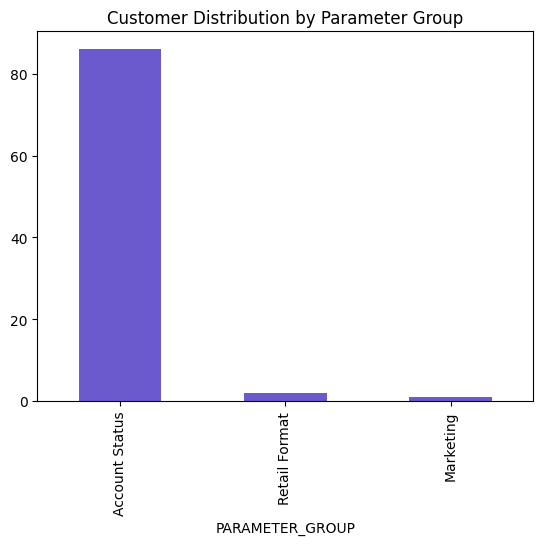

In [18]:
#Show how many customer-parameter pairs fall under each semantic group
merged_df_clean['PARAMETER_GROUP'].value_counts().plot(
    kind='bar', color='slateblue', title='Customer Distribution by Parameter Group')

<Axes: title={'center': 'Non-Account Status Parameter Distribution'}, xlabel='PARAMETER_GROUP'>

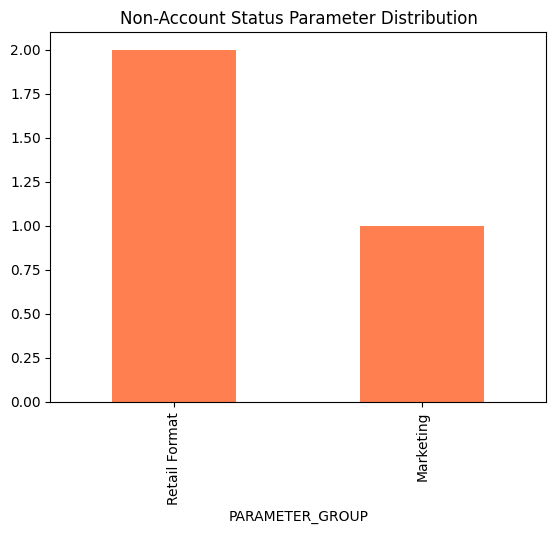

In [19]:
# Visualize how many customers fall under each non-status group
non_status_df['PARAMETER_GROUP'].value_counts().plot(
    kind='bar', color='coral', title='Non-Account Status Parameter Distribution'
)